# 네이버 영화리뷰 감성분석

In [5]:
%pip install konlpy torchinfo -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
!curl -L -o ratings_train.txt https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!curl -L -o ratings_test.txt  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 13.9M  100 13.9M    0     0  64.4M      0 --:--:-- --:--:-- --:--:-- 65.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4778k  100 4778k    0     0  66.5M      0 --:--:-- --:--:-- --:--:-- 68.6M


In [7]:
# 데이터로드
import pandas as pd                                   # 데이터프레임 처리를 위한 pandas 라이브러리

ratings_train_df = pd.read_csv('ratings_train.txt',  # 학습용 평점 데이터 파일 로드
                               sep='\t')             # 탭(\t)으로 구분된 파일
ratings_test_df = pd.read_csv('ratings_test.txt',    # 테스트용 평점 데이터 파일 로드
                              sep='\t')              # 탭(\t) 구분자 사용

len(ratings_train_df), len(ratings_test_df)           # 학습/테스트 데이터 개수 확인


(150000, 50000)

In [8]:
ratings_train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
ratings_test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [10]:
# 결측치제거
ratings_train_df = ratings_train_df.dropna(how='any')
ratings_test_df = ratings_test_df.dropna(how='any')

print(ratings_train_df.isnull().sum())
print(ratings_test_df.isnull().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


In [11]:
# 학습시간을 고려해서 데이터 샘플링
ratings_train_df = ratings_train_df.sample(n=50000, random_state=42)
ratings_test_df = ratings_test_df.sample(n=5000, random_state=42)
ratings_train_df.shape, ratings_test_df.shape

((50000, 3), (5000, 3))

## 데이터전처리

In [12]:
import re
from konlpy.tag import Okt

def preprocessing(sentence, okt=Okt()):
    # 개행문자 제거
    sentence = re.sub(r'\n', ' ', sentence)
    # 한글외 문자 제거
    sentence = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', '', sentence)
    # 형태소분석(어간추출)
    tokens = okt.morphs(sentence, stem=True)
    # 불용어제거
    stopwords = set(['에', '은', '는', '이', '가', '그리고', '것', '들', '수', '등', '로', '을', '를', '만', '도', '아', '의', '그', '다'])
    tokens = [token for token in tokens if token not in stopwords]
    return tokens

In [13]:
sample = """진짜 이상한 영화를 봤어요.
It's weird~~~~~~~~~~~~~~ ㅋㅋㅋㅋㅋ
8000원이 아까웠어요🤐🤐🤐
"""
preprocessing(sample)

['진짜', '이상하다', '영화', '보다', 'ㅋㅋㅋㅋㅋ', '원', '아깝다']

In [14]:
from tqdm import tqdm                                  # 진행 상황을 시각적으로 보여주는 라이브러리

X_train = []                                           # 학습용 입력 문장 리스트
y_train = []                                           # 학습용 라벨 리스트
X_test = []                                            # 테스트용 입력 문장 리스트
y_test = []                                            # 테스트용 라벨 리스트

for index, row in tqdm(ratings_train_df.iterrows()):   # 학습 데이터 한 행씩 순회 (진행바 표시)
    doc, label = row['document'], row['label']         # 리뷰 텍스트와 라벨 추출
    X_train.append(preprocessing(doc))                 # 전처리된 문장을 학습 입력에 저장
    y_train.append(label)                              # 라벨 저장

for index, row in tqdm(ratings_test_df.iterrows()):    # 테스트 데이터 한 행씩 순회
    doc, label = row['document'], row['label']         # 리뷰 텍스트와 라벨 추출
    X_test.append(preprocessing(doc))                  # 전처리된 문장을 테스트 입력에 저장
    y_test.append(label)                               # 라벨 저장


50000it [01:01, 814.70it/s] 
5000it [00:15, 316.96it/s]


In [15]:
X_train[:3]
y_train[:3]
X_test[:3]
y_test[:3]

[1, 1, 0]

In [16]:
# 정수인코딩/패딩 처리
from tensorflow.keras.preprocessing.text import Tokenizer        # 텍스트를 정수 시퀀스로 변환하는 도구
from tensorflow.keras.preprocessing.sequence import pad_sequences # 시퀀스 길이를 맞추기 위한 패딩 함수

vocab_size = 20000                                               # 사용할 최대 단어 사전 크기

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')   # 사전 크기 제한 + 미등록 단어 토큰 설정

tokenizer.fit_on_texts(X_train)                                  # 학습 데이터 기준으로 단어 사전 생성
X_train_encoded = tokenizer.texts_to_sequences(X_train)          # 학습 문장을 정수 시퀀스로 변환
X_test_encoded = tokenizer.texts_to_sequences(X_test)            # 테스트 문장을 정수 시퀀스로 변환

X_train_encoded[:3]                                              # 인코딩된 학습 데이터 일부 확인
X_test_encoded[:3]                                               # 인코딩된 테스트 데이터 일부 확인


[[1152, 268, 22, 4, 156, 28, 1576], [255, 251, 6], [1644, 5, 293]]

평균: 10.75, 중위값: 8.0


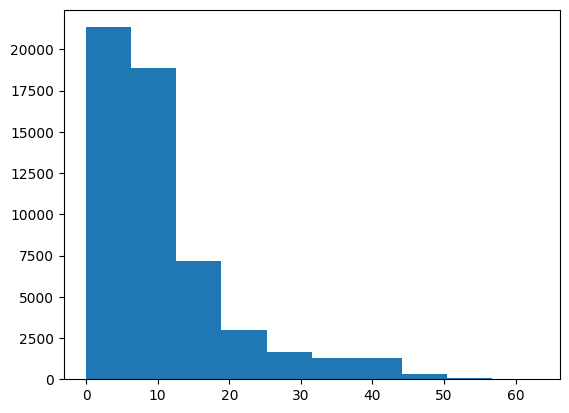

In [ ]:
# 리뷰길이 평균/중위값 확인
import matplotlib.pyplot as plt                     # 데이터 시각화를 위한 matplotlib
import numpy as np                                  # 수치 계산용 numpy

X_train_len = [len(seq) for seq in X_train_encoded] # 학습 데이터 각 리뷰 길이 계산
X_test_len = [len(seq) for seq in X_test_encoded]   # 테스트 데이터 각 리뷰 길이 계산

mean = np.mean(X_train_len + X_test_len)            # 전체 리뷰 길이 평균
median = np.median(X_train_len + X_test_len)        # 전체 리뷰 길이 중위값
print(f'평균: {mean:.2f}, 중위값: {median}')        # 평균과 중위값 출력

plt.hist(X_train_len + X_test_len)                  # 리뷰 길이 분포 히스토그램
plt.show()                                          # 그래프 출력


In [18]:
max_len = 15

X_train_padded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_len)

## 텍스트 디코딩

In [ ]:
# 단어사전
# - tokenizer.index_word : 인덱스 → 단어 매핑
# - tokenizer.word_index : 단어 → 인덱스 매핑

def decode_sentence(encoded_sentence):
    decoded = [tokenizer.index_word.get(n, '_')      # 인덱스를 단어로 변환 (없으면 '_' 처리)
               for n in encoded_sentence]            # 문장 시퀀스를 순회
    return ' '.join(decoded)                         # 단어들을 하나의 문장으로 결합

print(X_train_padded[0])                             # 패딩된 첫 번째 학습 데이터 출력
print(decode_sentence(X_train_padded[0]))            # 첫 번째 학습 데이터 디코딩 결과

print(ratings_test_df.iloc[0, 1])                    # 원본 테스트 데이터의 첫 번째 리뷰 출력
print(X_test_padded[0])                              # 패딩된 첫 번째 테스트 데이터 출력
print(decode_sentence(X_test_padded[0]))             # 첫 번째 테스트 데이터 디코딩 결과


[   0    0    0    0    0    0    0    0    0    0    0    0    0 8917
   28]
_ _ _ _ _ _ _ _ _ _ _ _ _ 원본 최고
찐한 여운과 함께...내 인생 최고의 미드
[   0    0    0    0    0    0    0    0 1152  268   22    4  156   28
 1576]
_ _ _ _ _ _ _ _ 찌다 여운 과 하다 인생 최고 미드


In [20]:
print(preprocessing('찐한 여운과 함께...내 인생 최고의 미드'))

['찌다', '여운', '과', '하다', '인생', '최고', '미드']


## 모델 설계

In [ ]:
import torch                                     # PyTorch 기본 라이브러리
import torch.nn as nn                            # 신경망 모듈 관련 클래스

class NSMC(nn.Module):                           # 양방향 LSTM 기반 감성분석 모델 정의
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()                       # nn.Module 초기화
        self.embedding = nn.Embedding(
            vocab_size,        # 단어 사전 크기 (임베딩 테이블의 행 개수)
            embedding_dim,     # 각 단어를 표현하는 벡터 차원
            padding_idx=0      # 0번 인덱스(PAD)는 항상 0 벡터로 유지되어 학습에 영향 없음
        )
        self.lstm = nn.LSTM(
            embedding_dim,     # 입력 벡터 차원 (Embedding 출력 크기)
            hidden_dim,        # LSTM 은닉 상태 차원 (한 방향 기준)
            batch_first=True,  # 입력/출력을 (batch, seq, feature) 형태로 사용
            bidirectional=True # 정방향 + 역방향 LSTM 사용
        )
        self.fc = nn.Linear(
            hidden_dim * 2,    # 정방향 + 역방향 은닉 상태를 concat한 크기
            1                  # 이진 분류용 출력 노드 (logit 1개)
        )

    def forward(self, x):
        x = self.embedding(x)                    # 단어 인덱스를 임베딩 벡터로 변환
        _, (hidden, _) = self.lstm(x)             # LSTM 통과 후 은닉 상태만 사용
        f_h = hidden[-2]                         # 정방향 LSTM 마지막 은닉 상태
        b_h = hidden[-1]                         # 역방향 LSTM 마지막 은닉 상태
        hidden = torch.cat((f_h, b_h), dim=1)    # 두 은닉 상태를 하나로 결합
        output = self.fc(hidden)                 # 결합된 은닉 상태로 예측
        return output                            # 최종 로짓 출력

embedding_dim = 100                              # 임베딩 벡터 차원
hidden_dim = 128                                 # LSTM 은닉 상태 차원
model = NSMC(vocab_size, embedding_dim, hidden_dim)  # 모델 인스턴스 생성
model                                           # 모델 구조 출력


NSMC(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [22]:
%pip install torchinfo -q
from torchinfo import summary
summary(model)

Note: you may need to restart the kernel to use updated packages.


Layer (type:depth-idx)                   Param #
NSMC                                     --
├─Embedding: 1-1                         2,000,000
├─LSTM: 1-2                              235,520
├─Linear: 1-3                            257
Total params: 2,235,777
Trainable params: 2,235,777
Non-trainable params: 0

## 모델 학습

In [ ]:
# tensor, dataset, dataloader 준비
batch_size = 64                                   # 학습 시 사용할 배치 크기
train_size = int(len(X_train_padded) * 0.8)       # 전체 학습 데이터의 80%를 train으로 사용
val_size = len(X_train_padded) - train_size       # 나머지 20%를 validation으로 사용

X_train_padded = torch.tensor(X_train_padded, dtype=torch.long)   # 학습 입력을 Long 타입 텐서로 변환
X_test_padded = torch.tensor(X_test_padded, dtype=torch.long)     # 테스트 입력을 Long 타입 텐서로 변환
y_train = torch.tensor(y_train, dtype=torch.float).unsqueeze(1)   # 학습 라벨을 (N, 1) 형태로 변환
y_test = torch.tensor(y_test, dtype=torch.float).unsqueeze(1)     # 테스트 라벨을 (N, 1) 형태로 변환

print(X_train_padded.shape, X_test_padded.shape)  # 학습/테스트 입력 텐서 크기 확인
print(y_train.shape, y_test.shape)                # 학습/테스트 라벨 텐서 크기 확인


torch.Size([50000, 15]) torch.Size([5000, 15])
torch.Size([50000, 1]) torch.Size([5000, 1])


In [30]:
from torch.utils.data import TensorDataset, DataLoader, random_split  # Dataset / DataLoader 관련 클래스

train_dataset = TensorDataset(X_train_padded, y_train)               # 학습 입력·라벨을 하나의 Dataset으로 묶기
train_dataset, val_dataset = random_split(                            # 학습 데이터를 train / val로 분리
    train_dataset,
    [train_size, val_size]
)
test_dataset = TensorDataset(X_test_padded, y_test)                  # 테스트 Dataset 생성

train_dataloader = DataLoader(                                       # 학습용 DataLoader
    train_dataset,
    batch_size=batch_size,
    shuffle=True                                                     # 학습 시 데이터 섞기
)
val_dataloader = DataLoader(                                         # 검증용 DataLoader
    val_dataset,
    batch_size=batch_size,
    shuffle=False                                                    # 검증 데이터는 순서 유지
)
test_dataloader = DataLoader(                                        # 테스트용 DataLoader
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(len(train_dataset), len(val_dataset), len(test_dataset))       # 각 Dataset 샘플 수 확인
print(len(train_dataloader), len(val_dataloader), len(test_dataloader))  # 배치 기준 step 수 확인


40000 10000 5000
625 157 79


In [ ]:
# 학습/검증
import torch.optim as optim                              # 옵티마이저 관련 모듈

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 결정

model = NSMC(vocab_size, embedding_dim, hidden_dim).to(device)  # 모델 생성 후 GPU/CPU로 이동
criterion = nn.BCEWithLogitsLoss()                    # 이진 분류용 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Adam 옵티마이저 설정
scheduler = optim.lr_scheduler.ReduceLROnPlateau(     # 검증 손실 기반 LR 감소 스케줄러
    optimizer,
    mode='min',                                       # 손실 최소화 기준
    factor=0.5,                                       # LR 감소 비율
    patience=3                                        # 개선 없을 때 대기 에폭 수
)

train_losses, val_losses, train_accs, val_accs = [], [], [], []  # 손실/정확도 기록용 리스트

# 조기종료 관련
early_stopping_patience = 1                            # 조기종료 허용 대기 에폭 수
best_val_loss = float('inf')                           # 최고(최소) 검증 손실 초기화
early_stopping_counter = 0                             # 조기종료 카운터

epochs = 100                                           # 최대 학습 에폭 수

for epoch in range(epochs):
    model.train()                                      # 학습 모드
    total_loss, correct, total = 0, 0, 0               # 에폭 누적 변수 초기화

    for x_batch, y_batch in train_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # 배치를 GPU로 이동

        optimizer.zero_grad()                          # 이전 gradient 초기화
        output = model(x_batch)                        # 순전파
        loss = criterion(output, y_batch)              # 손실 계산
        loss.backward()                                # 역전파
        optimizer.step()                               # 가중치 업데이트

        total_loss += loss.detach().cpu().item()       # 배치 손실 누적
        p = torch.sigmoid(output)                      # 로짓 → 확률
        pred = (p >= 0.5).float()                      # 0.5 기준 이진 예측
        correct += (pred == y_batch).sum().float().detach().cpu().item()  # 정답 수 누적
        total += len(y_batch)                          # 샘플 수 누적

    # 학습 기록
    train_loss = total_loss / len(train_dataloader)    # 에폭 평균 학습 손실
    train_acc = correct / total                        # 에폭 학습 정확도
    train_losses.append(train_loss)                    # 학습 손실 저장
    train_accs.append(train_acc)                       # 학습 정확도 저장

    # 검증
    model.eval()                                       # 평가 모드
    val_loss, val_correct, val_total = 0, 0, 0         # 검증 변수 초기화
    with torch.no_grad():                              # gradient 계산 비활성화
        for x_batch, y_batch in val_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # GPU 이동
            output = model(x_batch)                    # 순전파
            loss = criterion(output, y_batch)          # 손실 계산

            val_loss += loss.detach().cpu().item()     # 검증 손실 누적
            p = torch.sigmoid(output)                  # 확률 변환
            pred = (p >= 0.5).float()                  # 이진 예측
            val_correct += (pred == y_batch).sum().float().detach().cpu().item()  # 정답 수
            val_total += len(y_batch)                  # 샘플 수 누적

    val_loss = val_loss / len(val_dataloader)          # 에폭 평균 검증 손실
    val_acc = val_correct / val_total                  # 에폭 검증 정확도
    val_losses.append(val_loss)                        # 검증 손실 저장
    val_accs.append(val_acc)                           # 검증 정확도 저장

    # 스케줄러 검사
    scheduler.step(val_loss)                           # 검증 손실 기준으로 LR 조정
    lr = scheduler.get_last_lr()[0]                    # 현재 학습률 확인
    print(
        f'Epoch({epoch + 1}/{epochs}): '
        f'Train Loss {train_loss:.4f}, '
        f'Train Acc {train_acc:.4f}, '
        f'Val Loss {val_loss:.4f}, '
        f'Val Acc {val_acc:.4f}, '
        f'LR {lr}'
    )

    # 조기종료
    if val_loss < best_val_loss:                       # 검증 손실이 개선되면
        best_val_loss = val_loss                       # 최적 손실 갱신
        early_stopping_counter = 0                     # 카운터 초기화
    else:
        early_stopping_counter += 1                    # 개선 없으면 카운터 증가
        if early_stopping_counter >= early_stopping_patience:  # patience 초과 시
            print(f'Early stopped at Epoch {epoch + 1}...')     # 조기 종료
            break


Epoch(1/100): Train Loss 0.6422, Train Acc 0.6327, Val Loss 0.5639, Val Acc 0.6993, LR 0.0001
Epoch(2/100): Train Loss 0.5075, Train Acc 0.7466, Val Loss 0.4801, Val Acc 0.7598, LR 0.0001
Epoch(3/100): Train Loss 0.4392, Train Acc 0.7917, Val Loss 0.4507, Val Acc 0.7843, LR 0.0001
Epoch(4/100): Train Loss 0.4041, Train Acc 0.8160, Val Loss 0.4411, Val Acc 0.7890, LR 0.0001
Epoch(5/100): Train Loss 0.3779, Train Acc 0.8305, Val Loss 0.4346, Val Acc 0.7968, LR 0.0001
Epoch(6/100): Train Loss 0.3557, Train Acc 0.8458, Val Loss 0.4370, Val Acc 0.7970, LR 0.0001
Early stopped at Epoch 6...


In [26]:
train_losses, val_losses, train_accs, val_accs

([0.6421927938461304,
  0.5075258840560913,
  0.4391630966186523,
  0.40413168478012085,
  0.37792684633731843,
  0.3556620224714279],
 [0.5639291248124116,
  0.48014308806437594,
  0.4507105035387027,
  0.44106450221341126,
  0.43456127897948976,
  0.43702158142047326],
 [0.6327, 0.746625, 0.791725, 0.815975, 0.8305, 0.84575],
 [0.6993, 0.7598, 0.7843, 0.789, 0.7968, 0.797])

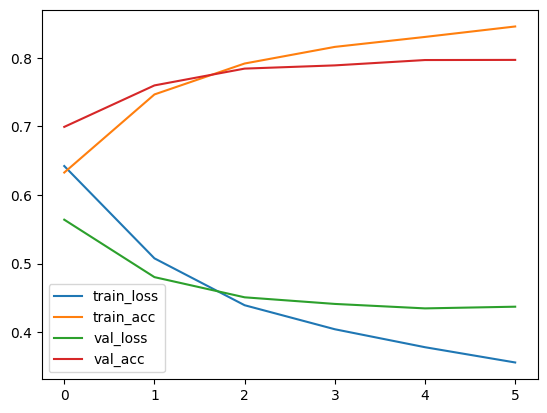

In [27]:
# 시각화
import matplotlib.pyplot as plt

history_df = pd.DataFrame({
    'train_loss': train_losses,
    'train_acc': train_accs,
    'val_loss': val_losses,
    'val_acc': val_accs
})
history_df.plot()
plt.show()

## 모델 평가

In [ ]:
model.eval()                                              # 모델을 평가 모드로 전환
test_loss, test_correct, test_total = 0.0, 0, 0           # 테스트 손실/정답/샘플 수 초기화

with torch.no_grad():                                     # gradient 계산 비활성화
    for x_batch, y_batch in test_dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # 배치를 GPU로 이동

        output = model(x_batch)                           # 순전파
        loss = criterion(output, y_batch)                 # 손실 계산
        test_loss += loss.detach().cpu().item()           # 배치 손실 누적

        p = torch.sigmoid(output)                          # 로짓 → 확률 변환
        pred = (p >= 0.5).float()                          # 0.5 기준 이진 예측
        test_correct += (pred == y_batch).sum().detach().cpu().item()  # 정답 개수 누적
        test_total += len(y_batch)                         # 전체 샘플 수 누적

test_loss = test_loss / len(test_dataloader)              # 평균 테스트 손실
test_acc = test_correct / test_total                      # 테스트 정확도 계산

print(f'Testset: Loss {test_loss:.4f}, Acc {test_acc:.4f}')  # 테스트 성능 출력


Testset: Loss 0.4521, Acc 0.7862


## 모델 추론

In [39]:
def movie_review_sentimental_analysis(sentences):          # 여러 문장을 입력받아 감성 분석하는 함수

    # 토큰화 / 전처리
    tokens = [preprocessing(sent) for sent in sentences]   # 각 문장을 전처리 함수로 토큰화

    # 정수 인코딩 / 패딩 처리
    encoded_sequences = tokenizer.texts_to_sequences(tokens)  # 토큰을 정수 인덱스 시퀀스로 변환
    padded_sequences = pad_sequences(                         # 모든 시퀀스를 동일한 길이로 패딩
        encoded_sequences,
        maxlen=max_len
    )

    # 텐서 변환
    X = torch.tensor(padded_sequences, dtype=torch.long).to(device)  # 모델 입력용 텐서 생성 후 GPU 이동

    model.eval()                                        # 모델을 평가 모드로 전환
    with torch.no_grad():                               # gradient 계산 비활성화
        output = model(X)                               # 모델 추론
        p = torch.sigmoid(output)                       # 로짓 → 확률 변환
        pred = (p >= 0.5).float()                       # 0.5 기준 이진 분류

        return ['긍정' if pr == 1 else '부정' for pr in pred]  # 예측 결과를 문자열로 반환


samples = [                                             # 테스트용 샘플 문장들
    '핵노잼',
    '짜증나',
    '왜만듦',
    '왜봄..?',
    '구려',
    '너무 유치'
]
movie_review_sentimental_analysis(samples)               # 샘플 문장 감성 분석 실행


['부정', '부정', '부정', '부정', '부정', '부정']